In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
plt.style.use('ggplot')

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
# CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 1
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018


#print(calculate.cliffsD([1, 2, 3, 4, 5, 9], [1, 2, 5, 6, 7, 9]))

## Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read authors with start and end year details

In [2]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
# authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
authorStartEndCareerData.head()

,author,start_year,end_year,num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender,early_career_qual,early_career_recognition,succ_after_15y,early_career_prod
0,'maseka lesaoana,2001,2015,2,15,14,7.5,True,none,23.0,5.0,23.0,1
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5,True,none,4.0,4.0,4.0,2
2,(zhou) bryan bai,2011,2012,2,2,14,7.5,True,none,0.0,0.0,0.0,2
3,a aart blokhuis,1992,2005,2,14,13,7.5,True,none,0.0,0.0,0.0,1
4,a ahrabian,2017,2017,1,1,15,15.0,True,none,0.0,0.0,0.0,1


### Read Citation data (uses paper->author network)

In [3]:
authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorCitationsData.rename(columns={'year_cit':'year', 'cit_count':'num_cit'}, inplace=True)

#### Tests

In [6]:
# 'maseka lesaoana published 2 publications in total, one in 2001 and one in 2015
# for the one is 2015 she did not get yet any citations
authorCitationsData[authorCitationsData["author"] == "'maseka lesaoana"]

,author,year,num_cit
0,'maseka lesaoana,2002,1
1,'maseka lesaoana,2003,1
2,'maseka lesaoana,2004,1
3,'maseka lesaoana,2005,2
4,'maseka lesaoana,2006,4
5,'maseka lesaoana,2007,1
6,'maseka lesaoana,2008,3
7,'maseka lesaoana,2009,1
8,'maseka lesaoana,2010,1
9,'maseka lesaoana,2012,1


In [7]:
# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
authorCitationsData[authorCitationsData["author"] == '(max) zong-ming cheng']

,author,year,num_cit
14,(max) zong-ming cheng,2009,1
15,(max) zong-ming cheng,2010,2
16,(max) zong-ming cheng,2013,1


In [11]:
# BUG: no zeros????
authorCitationsData["num_cit"].value_counts()

1       2333764
2       1102192
3        651606
4        438479
5        318124
6        242417
7        191742
8        156375
9        130649
10       110405
11        94135
12        81732
13        72071
14        63481
15        56514
16        51177
17        46018
18        41668
19        38021
20        35017
21        31704
22        29539
23        27329
24        25540
25        23550
26        21842
27        20763
28        19138
29        17848
30        16777
         ...   
1469          1
1471          1
1517          1
1557          1
1555          1
1550          1
1547          1
1537          1
1531          1
1528          1
1527          1
1526          1
1522          1
1520          1
1519          1
1515          1
1472          1
1506          1
1504          1
1500          1
1494          1
1490          1
1485          1
1483          1
1482          1
1478          1
1477          1
1475          1
1473          1
3937          1
Name: num_cit, Length: 1

### Merge citations with authors

In [12]:
authorCitationsData = authorCitationsData.merge(authorStartEndCareerData[['author', 'start_year', 'gender']], on='author')

### Citation distribution after 15 years

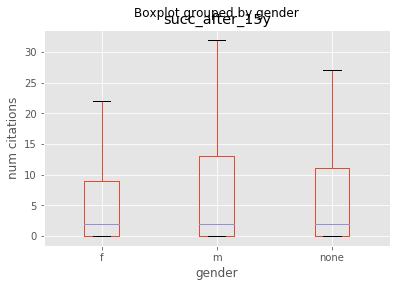

In [14]:
ax = authorStartEndCareerData.boxplot(column='succ_after_15y', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [15]:
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorCitationsData, 1, 'num_cit')

In [ ]:
groupByYearData.head()

In [16]:
years = authorCitationsData['year'].unique()
years = sorted(years)
print(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [42]:
from importlib import reload
reload(plot)

<module 'plot' from '/home/danielkostic/cumulative-advantage/plot.py'>

#### Tests

In [17]:
# some plausibility checks
print(groupByYearData.head(n=1))
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))

# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
# in 2011 he received 0 citations and after 2013 as well!!!
print(groupByYearData[groupByYearData["author"] == '(max) zong-ming cheng'])

   year     author  num_cit  start_year gender  cum_num_cit
0  1970  chin tung        1        1970   none            1
         year            author  num_cit  start_year gender  cum_num_cit
914809   2002  'maseka lesaoana        1        2001   none            1
1088252  2003  'maseka lesaoana        1        2001   none            2
1185057  2004  'maseka lesaoana        1        2001   none            3
1457140  2005  'maseka lesaoana        2        2001   none            5
1548274  2006  'maseka lesaoana        4        2001   none            9
1882335  2007  'maseka lesaoana        1        2001   none           10
2140771  2008  'maseka lesaoana        3        2001   none           13
2700909  2009  'maseka lesaoana        1        2001   none           14
2974211  2010  'maseka lesaoana        1        2001   none           15
3964452  2012  'maseka lesaoana        1        2001   none           16
         year                 author  num_cit  start_year gender  cum_num_cit

### Cohort Analysis (Num Cit)

plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


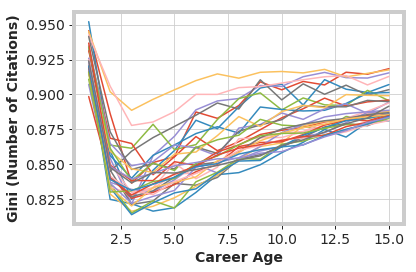

plot_cohort_size_gini_cor
plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


  cohort_start_year cohort_size age criterion      mean       std       sem  \
0              1970         763   1   num_cit  0.102228  0.425323  0.015398   

         median    mean_f  median_f     std_f     sem_f    mean_m  median_m  \
0  1.000000e-07  0.085714       0.0  0.368117  0.062223  0.079327       0.0   

      std_m     sem_m    mean_n  median_n     std_n    sem_n  
0  0.361561  0.017727  0.134615       0.0  0.501108  0.02837  
plot_cohort_means_over_ages


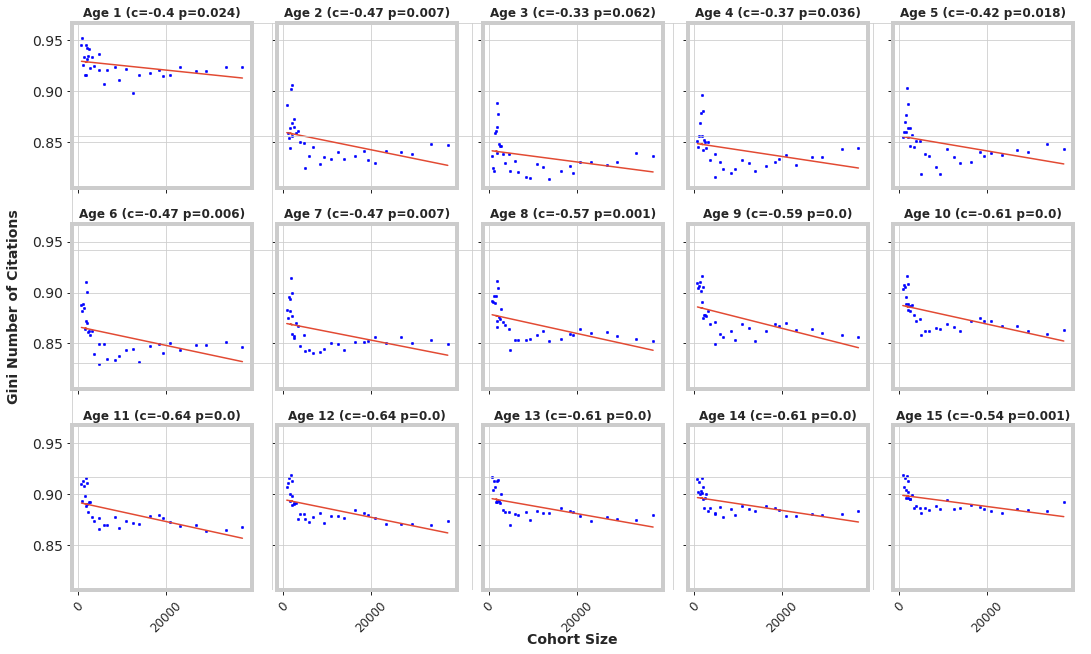

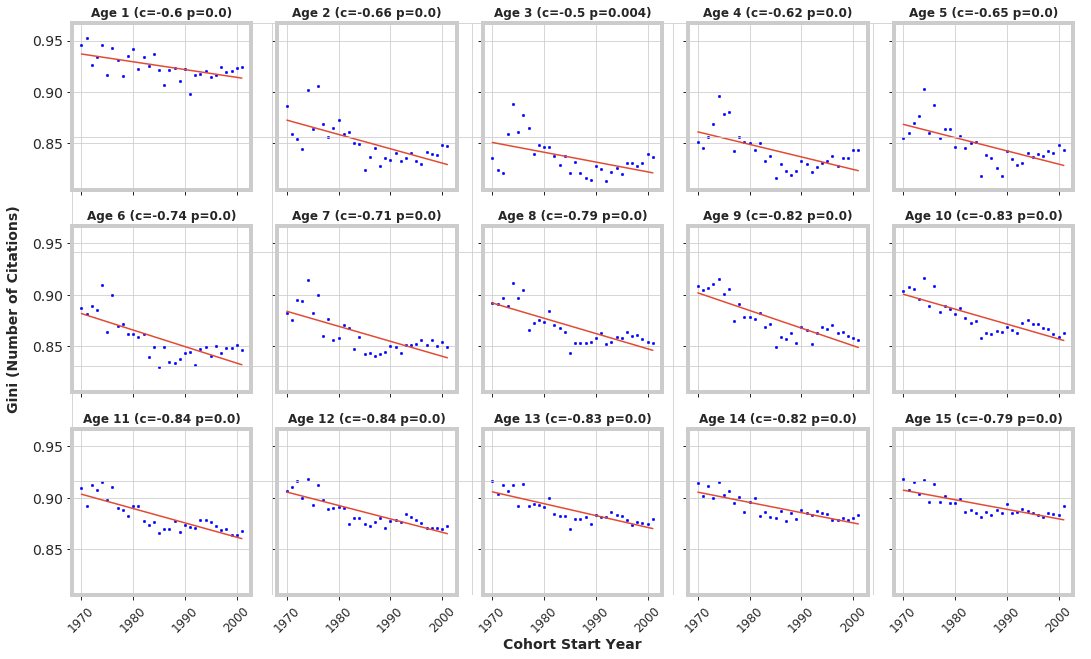

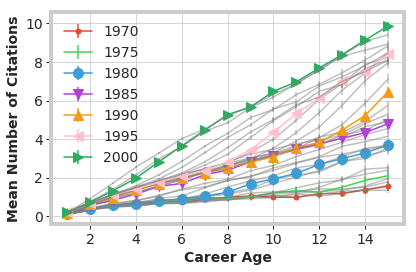

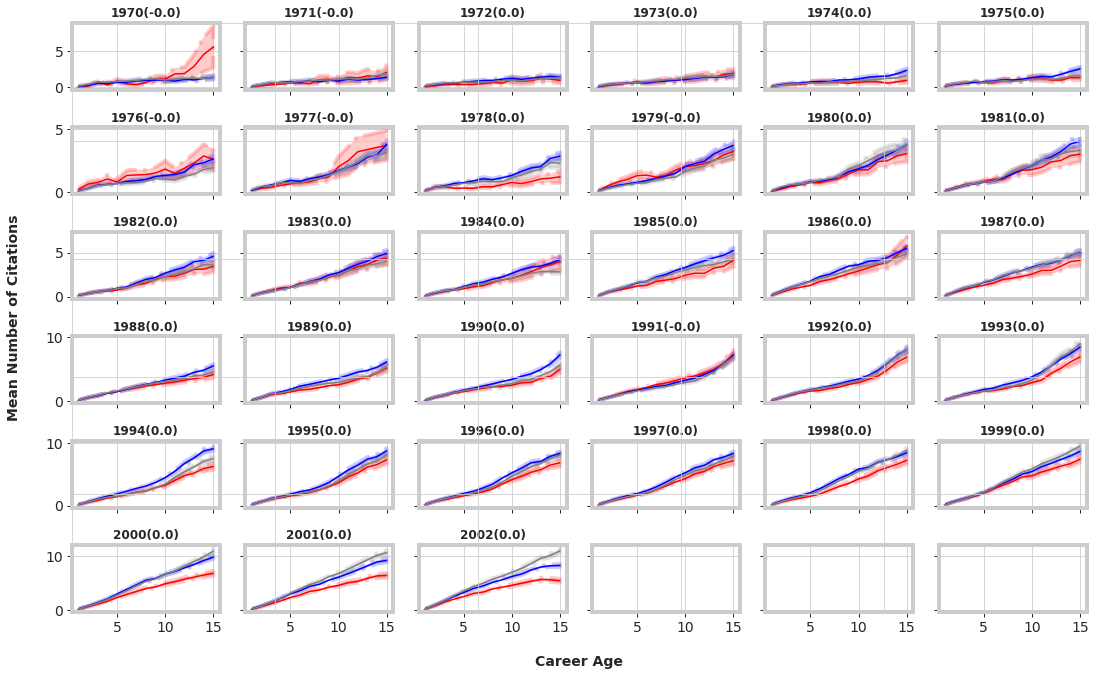

plot_gini


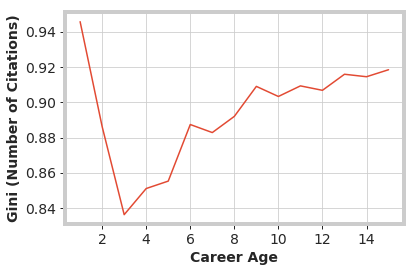

plot_gini


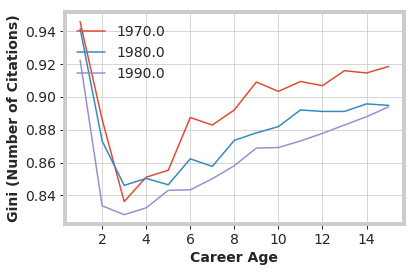

plot_cohort_effect_size


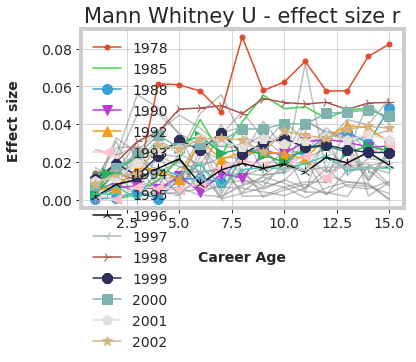

In [43]:
plot.run_cohort_analysis(authorCitationsData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_cit", "Number of Citations", authorStartEndCareerData)  

#### Tests

In [ ]:
from importlib import reload
reload(plot)

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_cit", authorStartEndCareerData)

#------------------------------------------

In [20]:
cohort_careerage_df.head()

,cohort_start_year,career_age,criterion,gender,values
0,1970,1,cum_num_cit,all,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1970,1,cum_num_cit,m,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1970,1,cum_num_cit,f,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ..."
3,1970,1,cum_num_cit,none,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1970,2,cum_num_cit,all,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
                              (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
                               (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))

<class 'pandas.core.series.Series'>
Counter({0.0: 10623, 1.0: 1256, 2.0: 325, 3.0: 110, 4.0: 60, 6.0: 18, 5.0: 11, 7.0: 9, 8.0: 6, 9.0: 4, 10.0: 3, 13.0: 2, 15.0: 1, 16.0: 1, 12.0: 1})
12430
<class 'pandas.core.series.Series'>
Counter({0.0: 3518, 1.0: 1366, 2.0: 922, 3.0: 662, 4.0: 510, 5.0: 447, 6.0: 353, 7.0: 281, 8.0: 244, 10.0: 243, 9.0: 231, 11.0: 170, 12.0: 166, 13.0: 154, 15.0: 149, 14.0: 142, 16.0: 123, 17.0: 108, 19.0: 102, 18.0: 101, 20.0: 97, 21.0: 85, 26.0: 67, 22.0: 66, 23.0: 66, 25.0: 63, 27.0: 57, 28.0: 55, 24.0: 51, 30.0: 51, 33.0: 49, 29.0: 49, 32.0: 49, 31.0: 48, 36.0: 47, 35.0: 41, 37.0: 39, 42.0: 39, 41.0: 38, 34.0: 38, 39.0: 36, 46.0: 35, 38.0: 35, 47.0: 32, 40.0: 32, 48.0: 30, 45.0: 27, 50.0: 26, 51.0: 25, 43.0: 24, 52.0: 23, 71.0: 23, 56.0: 22, 54.0: 22, 49.0: 22, 57.0: 21, 44.0: 21, 58.0: 21, 62.0: 19, 55.0: 18, 64.0: 17, 53.0: 17, 59.0: 16, 72.0: 15, 65.0: 15, 74.0: 15, 60.0: 15, 67.0: 13, 73.0: 13, 70.0: 12, 61.0: 12, 82.0: 11, 77.0: 10, 79.0: 10, 66.0: 9, 83.

### Cohort Analysis (Cum Num Cit)

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


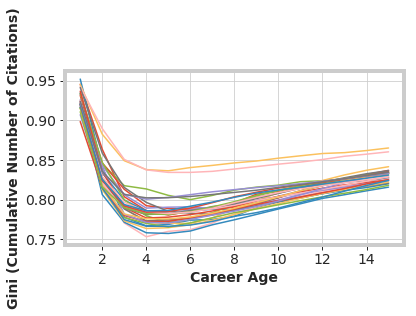

plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


  cohort_start_year cohort_size age    criterion      mean       std  \
0              1970         763   1  cum_num_cit  0.102228  0.425323   

        sem        median    mean_f  median_f     std_f     sem_f    mean_m  \
0  0.015398  1.000000e-07  0.085714       0.0  0.368117  0.062223  0.079327   

   median_m     std_m     sem_m    mean_n  median_n     std_n    sem_n  
0       0.0  0.361561  0.017727  0.134615       0.0  0.501108  0.02837  


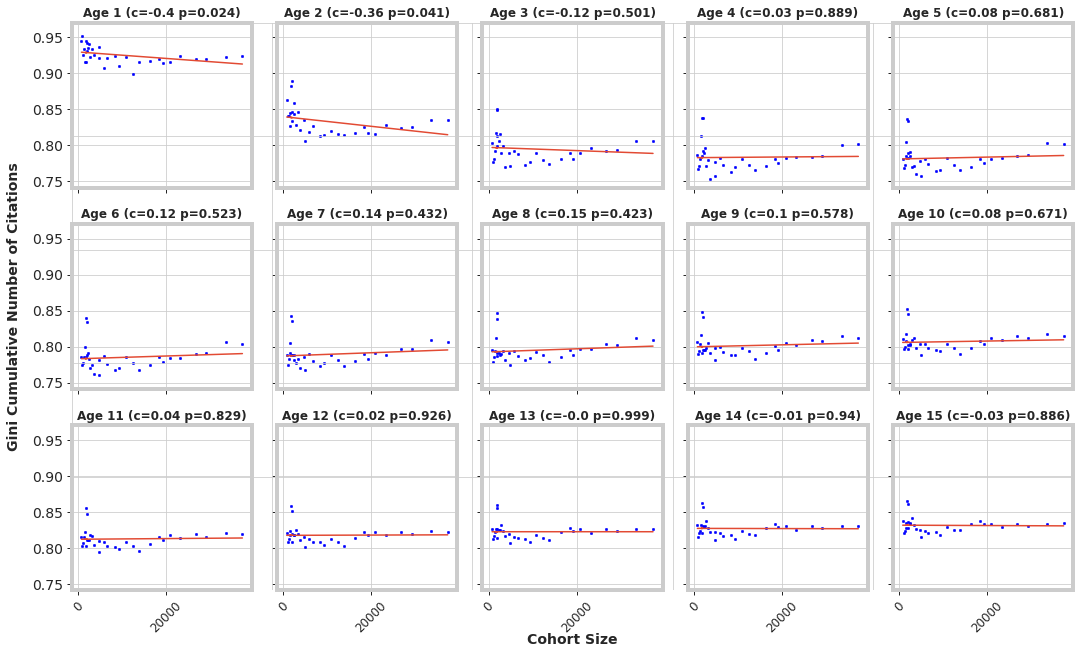

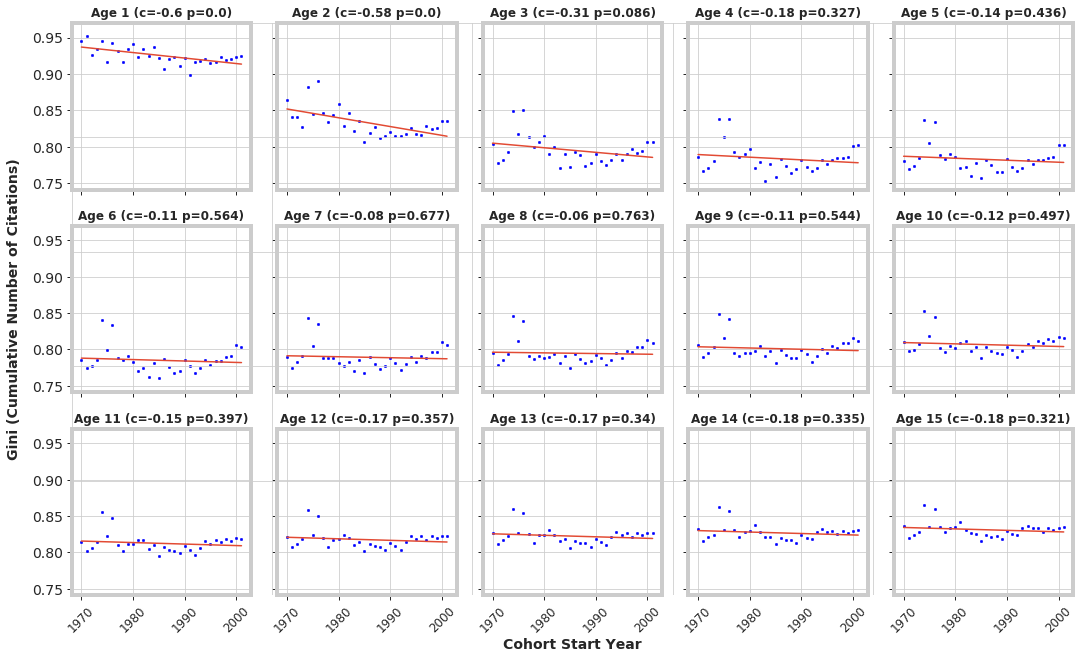

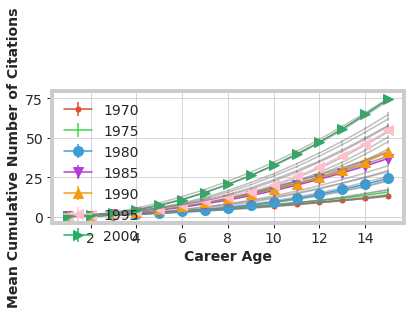

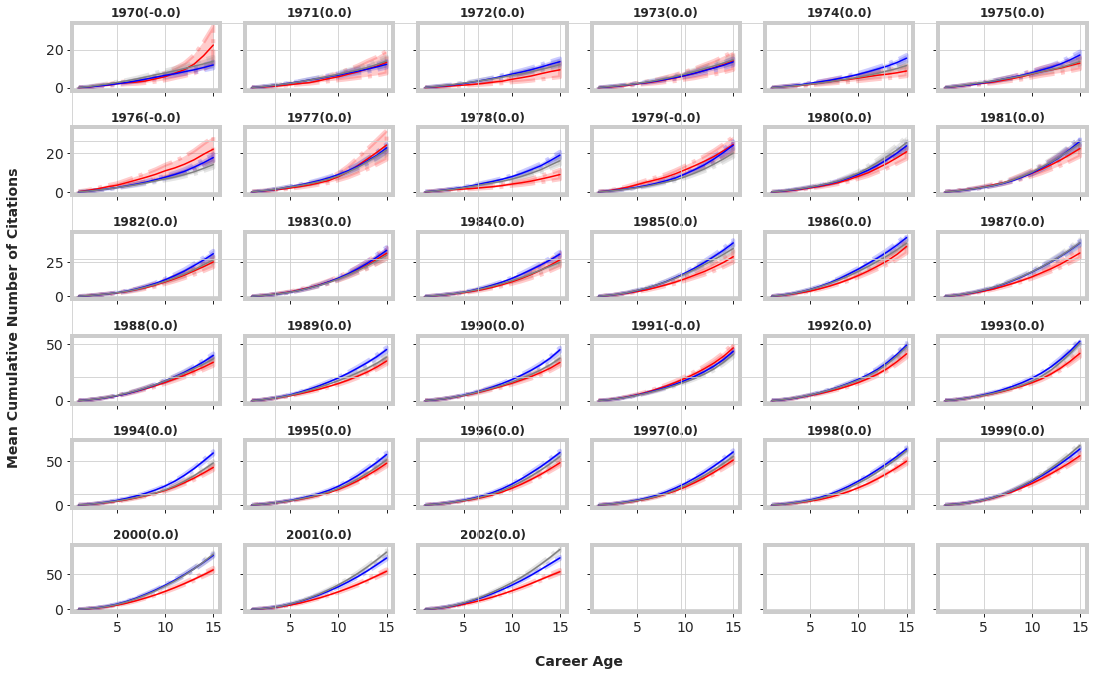

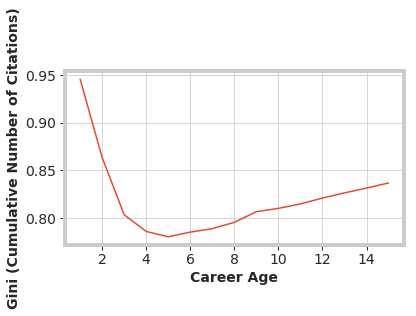

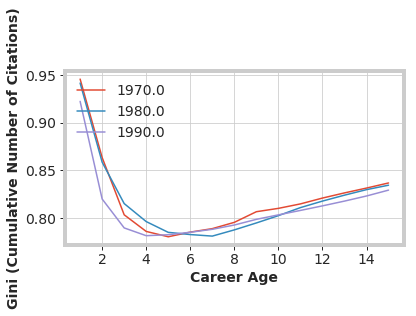

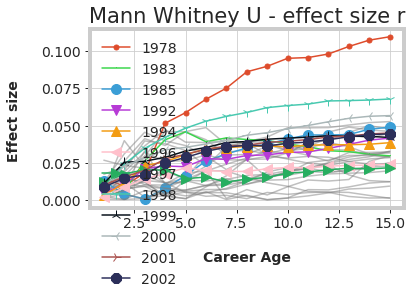

In [41]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, 
                         MAX_CAREER_LENGTH_COHORT, "cum_num_cit", "Cumulative Number of Citations", authorStartEndCareerData)  

# What should i do with the rest of this notebook?

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

In [ ]:
# cohort_start_years = [1974, 1975, 1976, 1979, 2000]

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [ ]:
# _1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1975] 
# _1985Authors.shape

In [ ]:
# _1985Authors.columns

In [ ]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [ ]:
# _1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
# _1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
# print(_1995_2000_year_1985Authors.shape)
# _1995_2000_year_1985Authors.head(10)

In [ ]:
# temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
# temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
# temp.head()

# #print(temp1['id2'].unique())

In [ ]:
# donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
# donatella

In [ ]:
# plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [ ]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [ ]:
#just for debugging
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [ ]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)